In [1]:
import random
random.seed(42)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dataset_loader
import torchvision

import cv2
import numpy as np 

import matplotlib.pyplot as plt

In [2]:
# cifar_dataset = dataset_loader.CIFAR100('./assets/cifar-100', train=True, download=True, transform=torchvision.transforms.ToTensor())
cifar_dataset = dataset_loader.CIFAR10('./assets/cifar-10', train=True, download=True, transform=torchvision.transforms.ToTensor())


Files already downloaded and verified


In [3]:
cifar_dataset = cifar_dataset.data

(Text(0.5, 1.0, 'RGB'), Text(0.5, 1.0, 'Gray'))

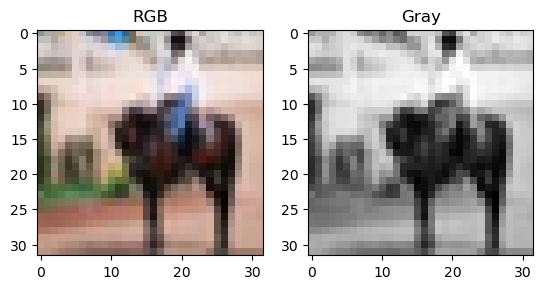

In [4]:
f, ax = plt.subplots(1,2)
ax[0].imshow(cifar_dataset[11])
ax[1].imshow(cv2.cvtColor(cifar_dataset[11], cv2.COLOR_RGB2GRAY),cmap='gray')
ax[0].set_title('RGB'), ax[1].set_title('Gray')

In [5]:
# Creating input and output data
batch_size = 100
op_data = np.array([cifar_dataset[_ix:_ix+batch_size] for _ix in range(0, cifar_dataset.shape[0], batch_size)])
ip_data = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in cifar_dataset])
ip_data = np.array([ip_data[_ix:_ix+batch_size] for _ix in range(0, ip_data.shape[0], batch_size)])

# Splitting the data
train_ratio, test_ratio = 0.8, 0.2
rand_ix = np.random.permutation(ip_data.shape[0])
train_ix, test_ix = rand_ix[:int(train_ratio*rand_ix.shape[0])], rand_ix[int(test_ratio*rand_ix.shape[0]):]
x_train, y_train, x_test, y_test = ip_data[train_ix,:,:], op_data[train_ix,:,:], ip_data[test_ix,:,:], op_data[test_ix,:,:]

(Text(0.5, 1.0, 'x_train'), Text(0.5, 1.0, 'y_train'))

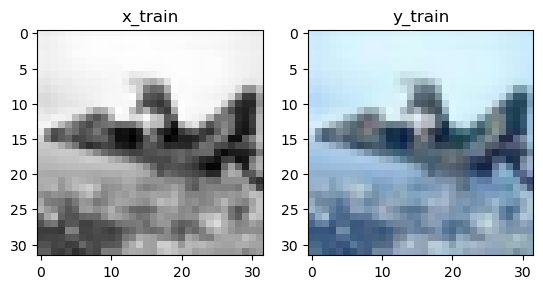

In [6]:
f, ax_1 = plt.subplots(1,2)
ax_1[0].imshow(x_train[0][0], cmap='gray')
ax_1[1].imshow(y_train[0][0])
ax_1[0].set_title('x_train'), ax_1[1].set_title('y_train')

In [7]:
def transform_and_create_torch_tensors(data):
    # reshaping the input and accelerate the tensor computations
    data = torch.from_numpy(data).float()
    return data.contiguous().view(data.size(0),batch_size,-1,32,32)

# transforming all the data.
x_train, y_train, x_test, y_test = map(transform_and_create_torch_tensors, [x_train, y_train, x_test, y_test])

In [8]:
mean = torch.mean(x_train[:,:,0,:,:])
std = torch.std(x_train[:,:,0,:,:])
print('mean: {}, std: {}'.format(mean, std))
x_train[:,:,0,:,:] = (x_train[:,:,0,:,:]-mean)/std
x_test[:,:,0,:,:] = (x_test[:,:,0,:,:]-mean)/std # using the mean and std from the training dataset
y_train = y_train/255
y_test = y_test/255

mean: 122.67642211914062, std: 61.046817779541016


In [9]:
"""class ConvNet(nn.Module):
    def __init__(self, batch_size):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.linear1 = nn.Linear(32*7*7, 512)
        self.linear2 = nn.Linear(512, 3072)

    def forward(self, x):
        # Encoder Phase
        p1 = F.max_pool2d(self.conv1(x), (2,2))
        p2 = F.max_pool2d(self.conv2(p1), (2,2))
        # Decoder Phase
        f1 = F.relu(self.linear1(p2.view(batch_size,-1)))
        f2 = torch.sigmoid(self.linear2(f1)).view(-1, 3, 32, 32)
        return f2"""

class ConvNet(nn.Module):
    def __init__(self, batch_size):
        super(ConvNet, self).__init__()
        self.batch_size = batch_size
        
        # Encoder Phase
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # Increased number of filters
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Decoder Phase (fully connected layers)
        self.fc1 = nn.Linear(128*4*4, 512)
        self.fc2 = nn.Linear(512, 3072)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # Encoder Phase
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        # Flatten the tensor
        x = x.view(self.batch_size, -1)
        
        # Decoder Phase
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x)).view(-1, 3, 32, 32)
        
        return x

In [10]:
learning_rate = 0.0001
epochs = 50
criterion = torch.nn.MSELoss()

In [11]:
net = ConvNet(batch_size)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [12]:
train_loss_container, test_loss_container = [], []

for e in range(epochs):
    train_loss = 0.0
    test_loss = 0.0

    for batch, train_data in enumerate(x_train):
        ip, op = train_data, y_train[batch]
        optimizer.zero_grad()

        model_op = net(ip)
        loss = criterion(model_op, op)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        for batch_test, test_data in enumerate(x_test, 0):
            ip_test, op_test = test_data, y_test[batch_test]
            model_op = net(ip_test)
            loss_test = criterion(model_op, op_test)
            test_loss += loss_test.item()

    train_loss_container.append(train_loss)
    test_loss_container.append(test_loss)
    print('\rEPOCH: {} | Train_loss: {} | Test_loss: {}'.format(e, train_loss, test_loss), end='')
print('\nFinished Training')

TypeError: iteration over a 0-d tensor

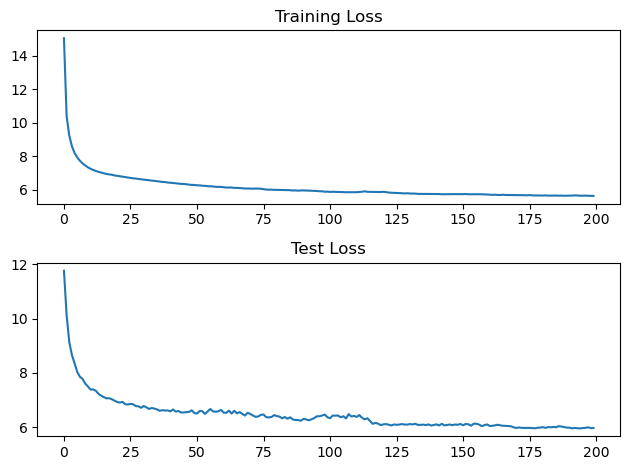

In [ ]:
# Plotting the train and test loss as a function of epochs
f, ax = plt.subplots(2,1)
ax[0].set_title('Training Loss')
ax[0].plot(train_loss_container)
ax[1].set_title('Test Loss')
ax[1].plot(test_loss_container)
f.tight_layout()
plt.show()

In [ ]:
import os
# Save the model
save_dir = './saved_model/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Construct the path for saving the model file and save model at path
model_path = os.path.join(save_dir, 'something1.pth')
torch.save(net.state_dict(), model_path)
print(f'Model saved at {model_path}')

# Load the saved model
model_path = './saved_model/something1.pth'  # Update this path to your model file
batch_size = 100
model = ConvNet(batch_size)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

Model saved at ./saved_model/something.pth


C:\Users\tyler\AppData\Local\Temp\ipykernel_17624\1206476116.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=t

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3072, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


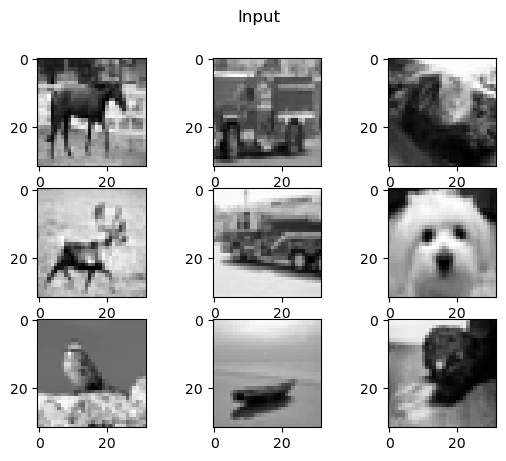

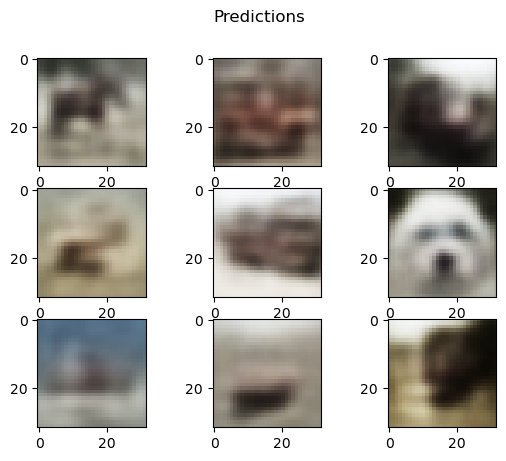

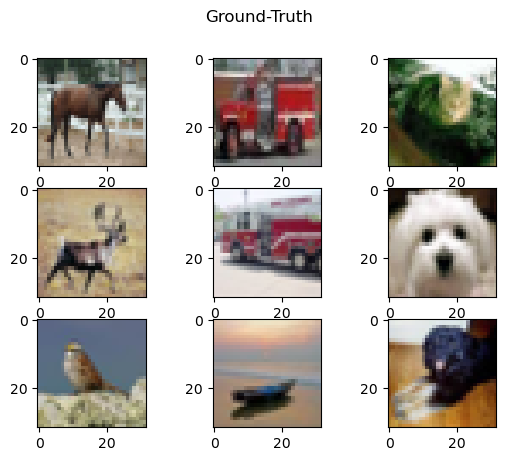

In [ ]:
# input
f, ax = plt.subplots(3,3)
f.suptitle('Input')
for i in range(3):
    for j in range(3):
        tmp = mean.item() + x_test[i][j].detach().cpu().squeeze().numpy() * std.item()
        ax[i,j].imshow(tmp.reshape(32,32).astype(np.uint8), cmap='gray')

# prediction
f, ax = plt.subplots(3,3)
f.suptitle('Predictions')
for i in range(3):
    for j in range(3):
        tmp = model(x_test[i])[j].detach().cpu().numpy().reshape(32,32,3) * 255
        print(tmp.shape)
        ax[i,j].imshow(tmp.astype(np.uint8))
        
# ground truth
f, ax = plt.subplots(3,3)
f.suptitle('Ground-Truth')
for i in range(3):
    for j in range(3):
        tmp = y_test[i][j].detach().cpu().numpy()*255
        ax[i,j].imshow(tmp.reshape(32,32,3).astype(np.uint8))